### Подгружаем библиотеки

In [26]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import random
import os
from torch import nn
from torch.nn import functional as F
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')
plt.rcParams["figure.figsize"] = (15,3)

In [27]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

### Подгружаем данные

In [107]:
norm_data = pd.read_csv('df_normalized.csv', sep=';')

In [108]:
features = ['id', 'k_means_cluster', 'lda_topic_0_proba', 'lda_topic_1_proba', 'lda_topic_2_proba', 'lda_topic_3_proba', 'lda_topic_4_proba', 'lda_topic_5_proba', 'lda_topic_6_proba', 'lda_topic_7_proba', 'lda_topic_8_proba', 'lda_topic_9_proba', 'lda_topic_10_proba', 'lda_topic_11_proba', 'lda_topic_12_proba', 'lda_topic_13_proba', 'lda_topic_14_proba']
train_ft = pd.read_csv('train.csv', sep=';')[features]
test_ft = pd.read_csv('test.csv', sep=';')[features]

In [109]:
features = pd.concat([train_ft, test_ft])

In [110]:
norm_data = norm_data.merge(features, how='inner', on='id')
norm_data = norm_data.drop(columns=['overview', 'id', 'vote_label'], axis=1)

In [113]:
def split_data(data):
    y = data['vote_average']
    X = data.drop(columns=['vote_average'], axis=1)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [114]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [115]:
class MinMaxSeries():
    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, sample):
        self.min = sample.min()
        self.max = sample.max()

    def transform(self, sample):
        return (sample - self.min) / (self.max - self.min)

    def inverse_transform(self, sample):
        return sample * (self.max - self.min) + self.min

### Архитектура

In [116]:
class PandasDataset(torch.utils.data.Dataset):

  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return {
        'sample': torch.tensor(self.x.iloc[idx,:], dtype=torch.float32),
        'target': torch.tensor(self.y.iloc[idx], dtype=torch.float32)
    }

In [117]:
def plot_loss(train_loss, val_loss, test_loss):
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(12)

    ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2)
    ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=1)
    ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), colspan=1)

    ax1.plot(train_loss)
    ax1.set_title('Train')
    ax1.set_ylabel('MSE')
    ax1.set_xlabel('iter')
    ax1.set_yscale('log')

    ax2.plot(val_loss)
    ax2.set_title('Val')
    ax2.set_ylabel('MSE')
    ax2.set_xlabel('iter')

    ax3.plot(test_loss)
    ax3.set_title('Test')
    ax3.set_ylabel('MSE')
    ax3.set_xlabel('iter')

    plt.tight_layout()
    plt.show()

In [118]:
def train(model, data_loader, optimizer, loss_fn, device):
    model.train()
    batch_loss = []

    for batch in tqdm(data_loader, desc='Training'):
        X = batch['sample'].to(device)
        y = batch['target'].to(device)

        y_pred = model(X).squeeze(1)
        loss = loss_fn(y_pred, y).cpu()
        batch_loss.append(loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    return batch_loss

In [119]:
@torch.inference_mode()
def evaluate(model, data_loader, loss_fn, device, data_set, transformer=None):
    model.eval()
    batch_loss = []
    for batch in tqdm(data_loader, desc=f'Evaluate {data_set}'):
        X = batch['sample'].to(device)
        y = batch['target'].to(device)
        pred = model(X).squeeze(1)
        if transformer is not None:
          inv_pred = transformer.inverse_transform(pred.cpu())
          inv_y = transformer.inverse_transform(y.cpu())
          loss = loss_fn(inv_pred, inv_y)
          batch_loss.append(loss)

        else:
          loss = loss_fn(pred, y).cpu()
          batch_loss.append(loss.item())

    return batch_loss

In [120]:
def fit(model, train_loader, val_loader, test_loader, optimizer, loss_fn, num_epochs, device, transformer=None, verbose=True):
    train_loss_history, val_loss_history, test_loss_history = [], [], []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        val_loss = evaluate(model, val_loader, loss_fn, device, 'validation', transformer)
        test_loss = evaluate(model, test_loader, loss_fn, device, 'test', transformer)

        train_loss_history += train_loss
        val_loss_history += val_loss
        test_loss_history += test_loss

        scheduler.step()

        clear_output()

        rmse = np.sqrt(np.mean(test_loss))
        print(f'Epoch: {epoch+1}')
        print(f'Test RMSE: {rmse}')
        if verbose == True:
            plot_loss(train_loss_history, val_loss_history, test_loss_history)

    return rmse

### Бейзлайн

1. 2 слоя (64 нейронов)
2. Adam
3. lr = 1e-4
3. StepLR(gamma=0.9)

In [121]:
seed_everything(42)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(norm_data)

target_scaler = MinMaxSeries()
target_scaler.fit(y_train)

y_train = target_scaler.transform(y_train)
y_val = target_scaler.transform(y_val)
y_test = target_scaler.transform(y_test)

train_set = PandasDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, worker_init_fn=42, batch_size=64)

val_set = PandasDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, worker_init_fn=42, batch_size=64)

test_set = PandasDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, worker_init_fn=42, batch_size=64)

Epoch: 5
Test RMSE: 1.8112199306488037


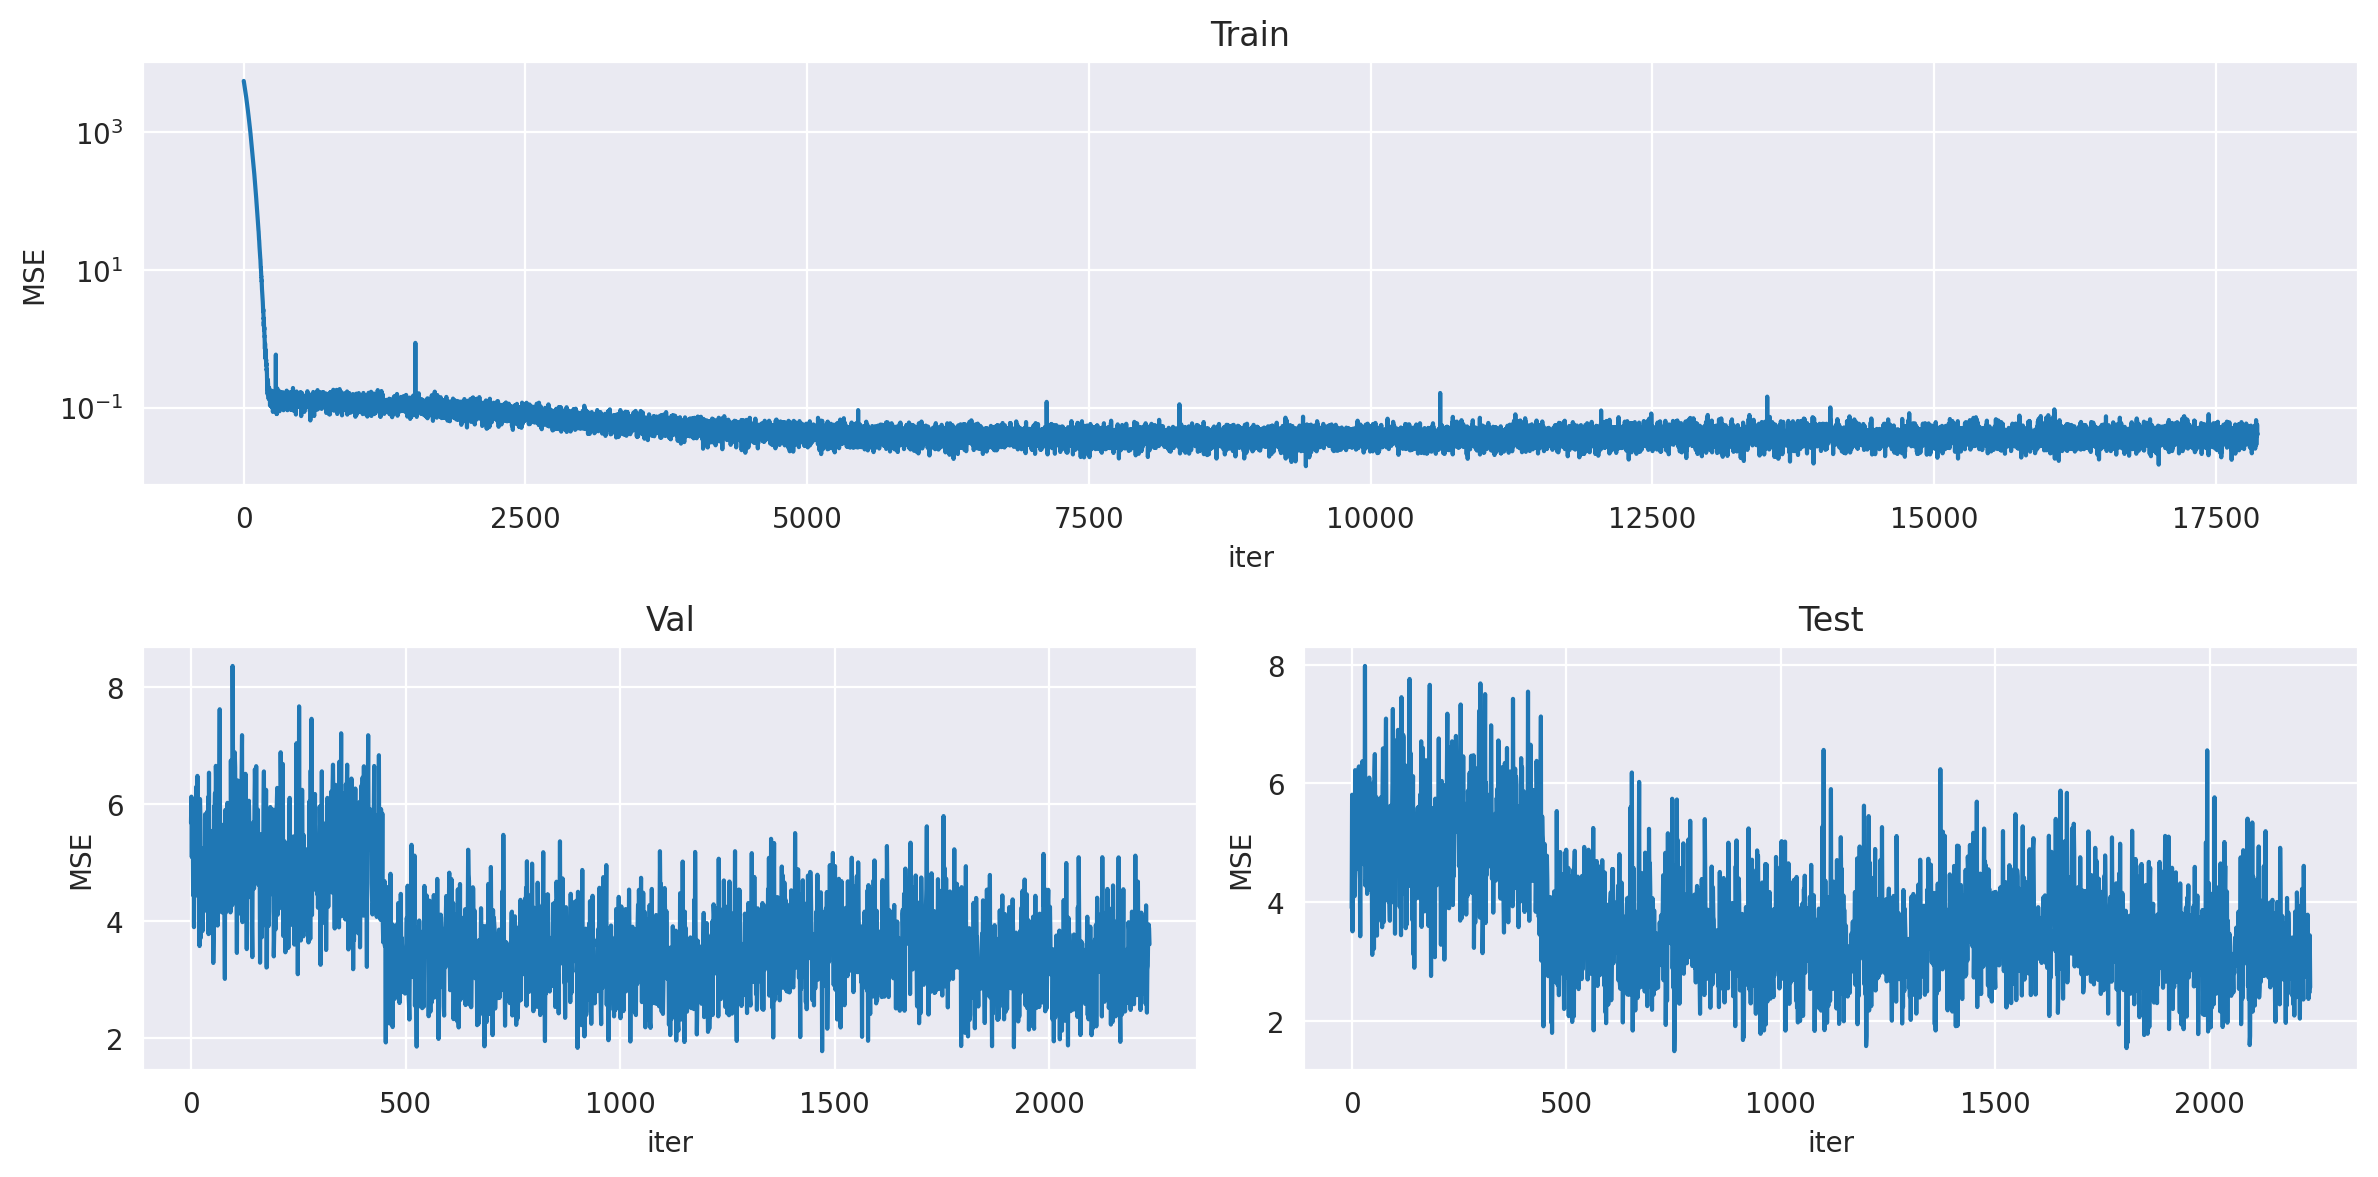

1.8112199

In [122]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 64)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

### Нарастим нейронов:
1. 2 слоя (128 нейронов)
2. Adam
3. lr = 1e-3
4. StepLR(gamma=0.9)

Epoch: 5
Test RMSE: 1.8497365713119507


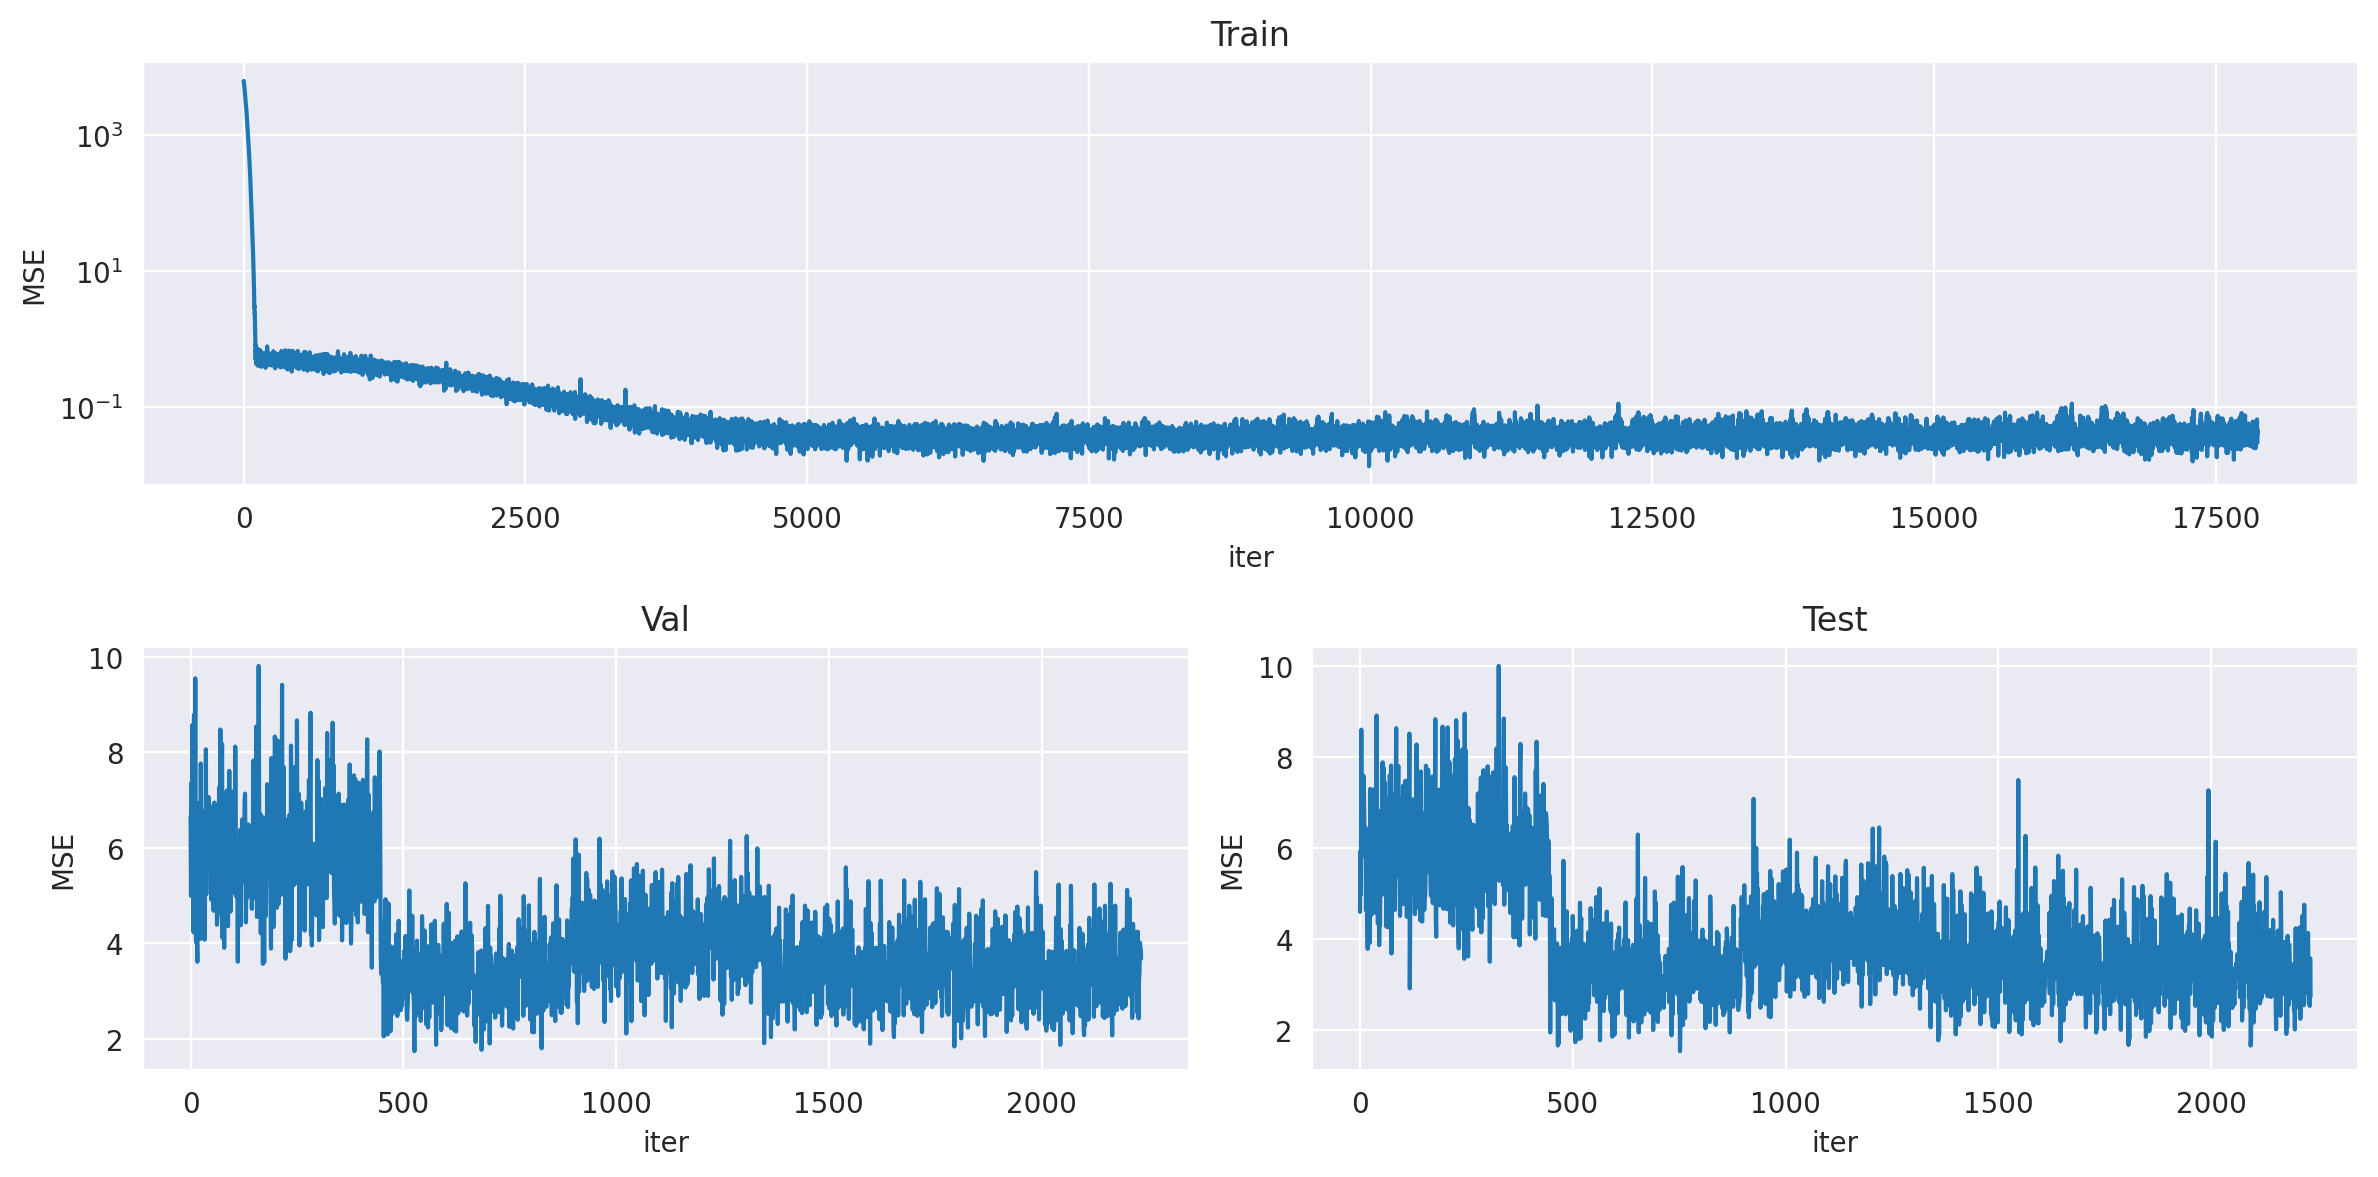

1.8497366

In [123]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

### Поставим CosineAnnealingLR:
1. 2 слоя (128 нейронов)
2. Adam
3. lr = 1e-4
4. CosineAnnealingLR

Epoch: 5
Test RMSE: 1.8112809658050537


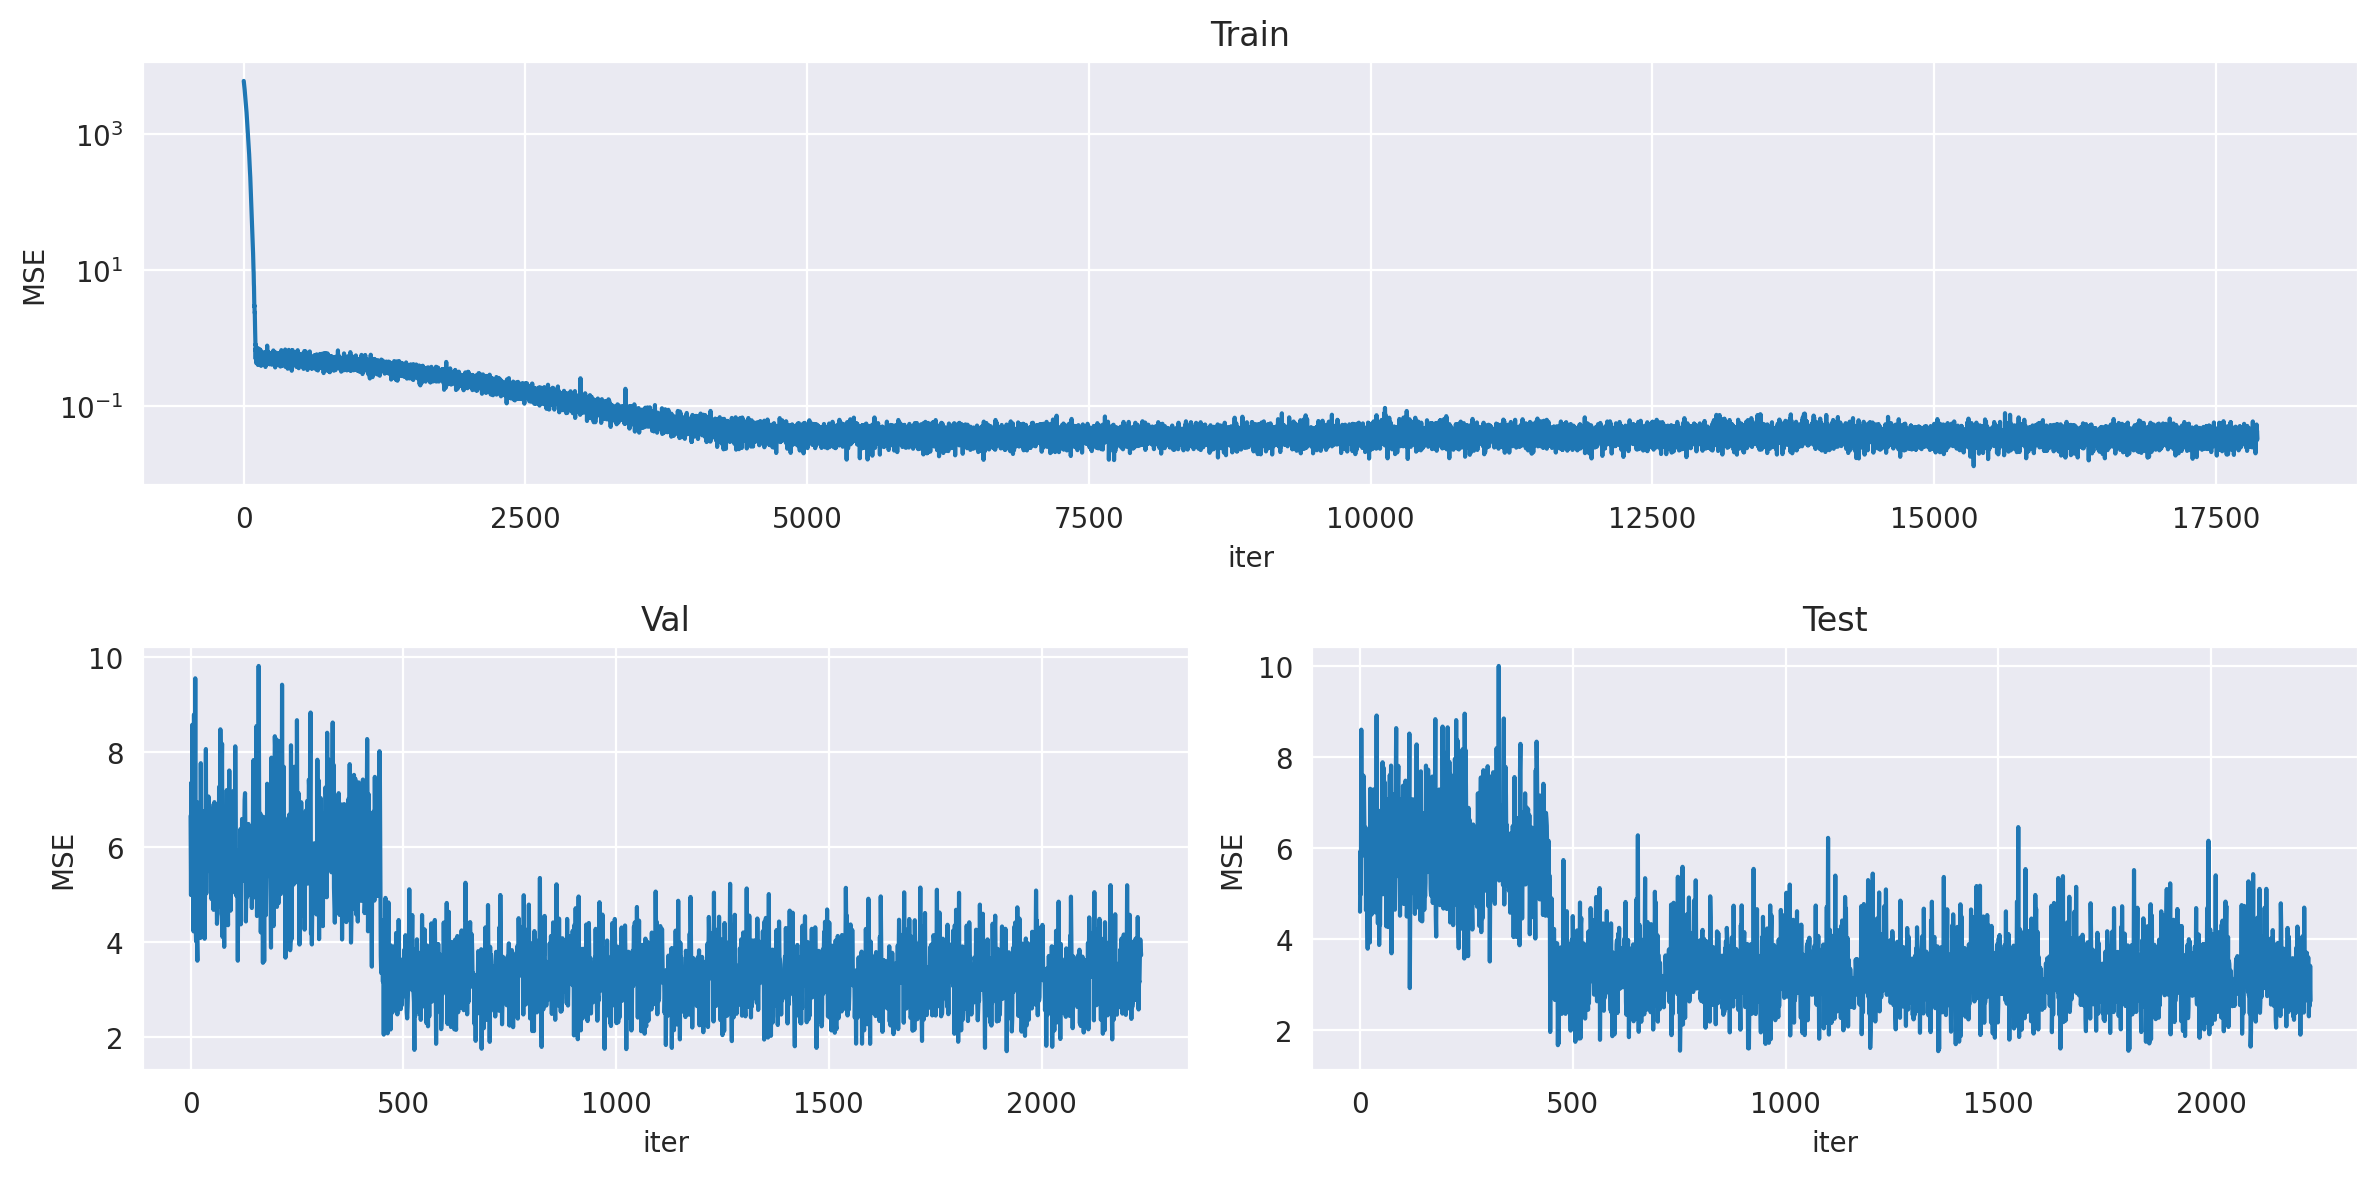

1.811281

In [124]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

### Поставим AdamW:
1. 2 слоя (128 нейронов)
2. AdamW
3. lr = 1e-4
4. CosineAnnealingLR

Epoch: 5
Test RMSE: 1.8109166622161865


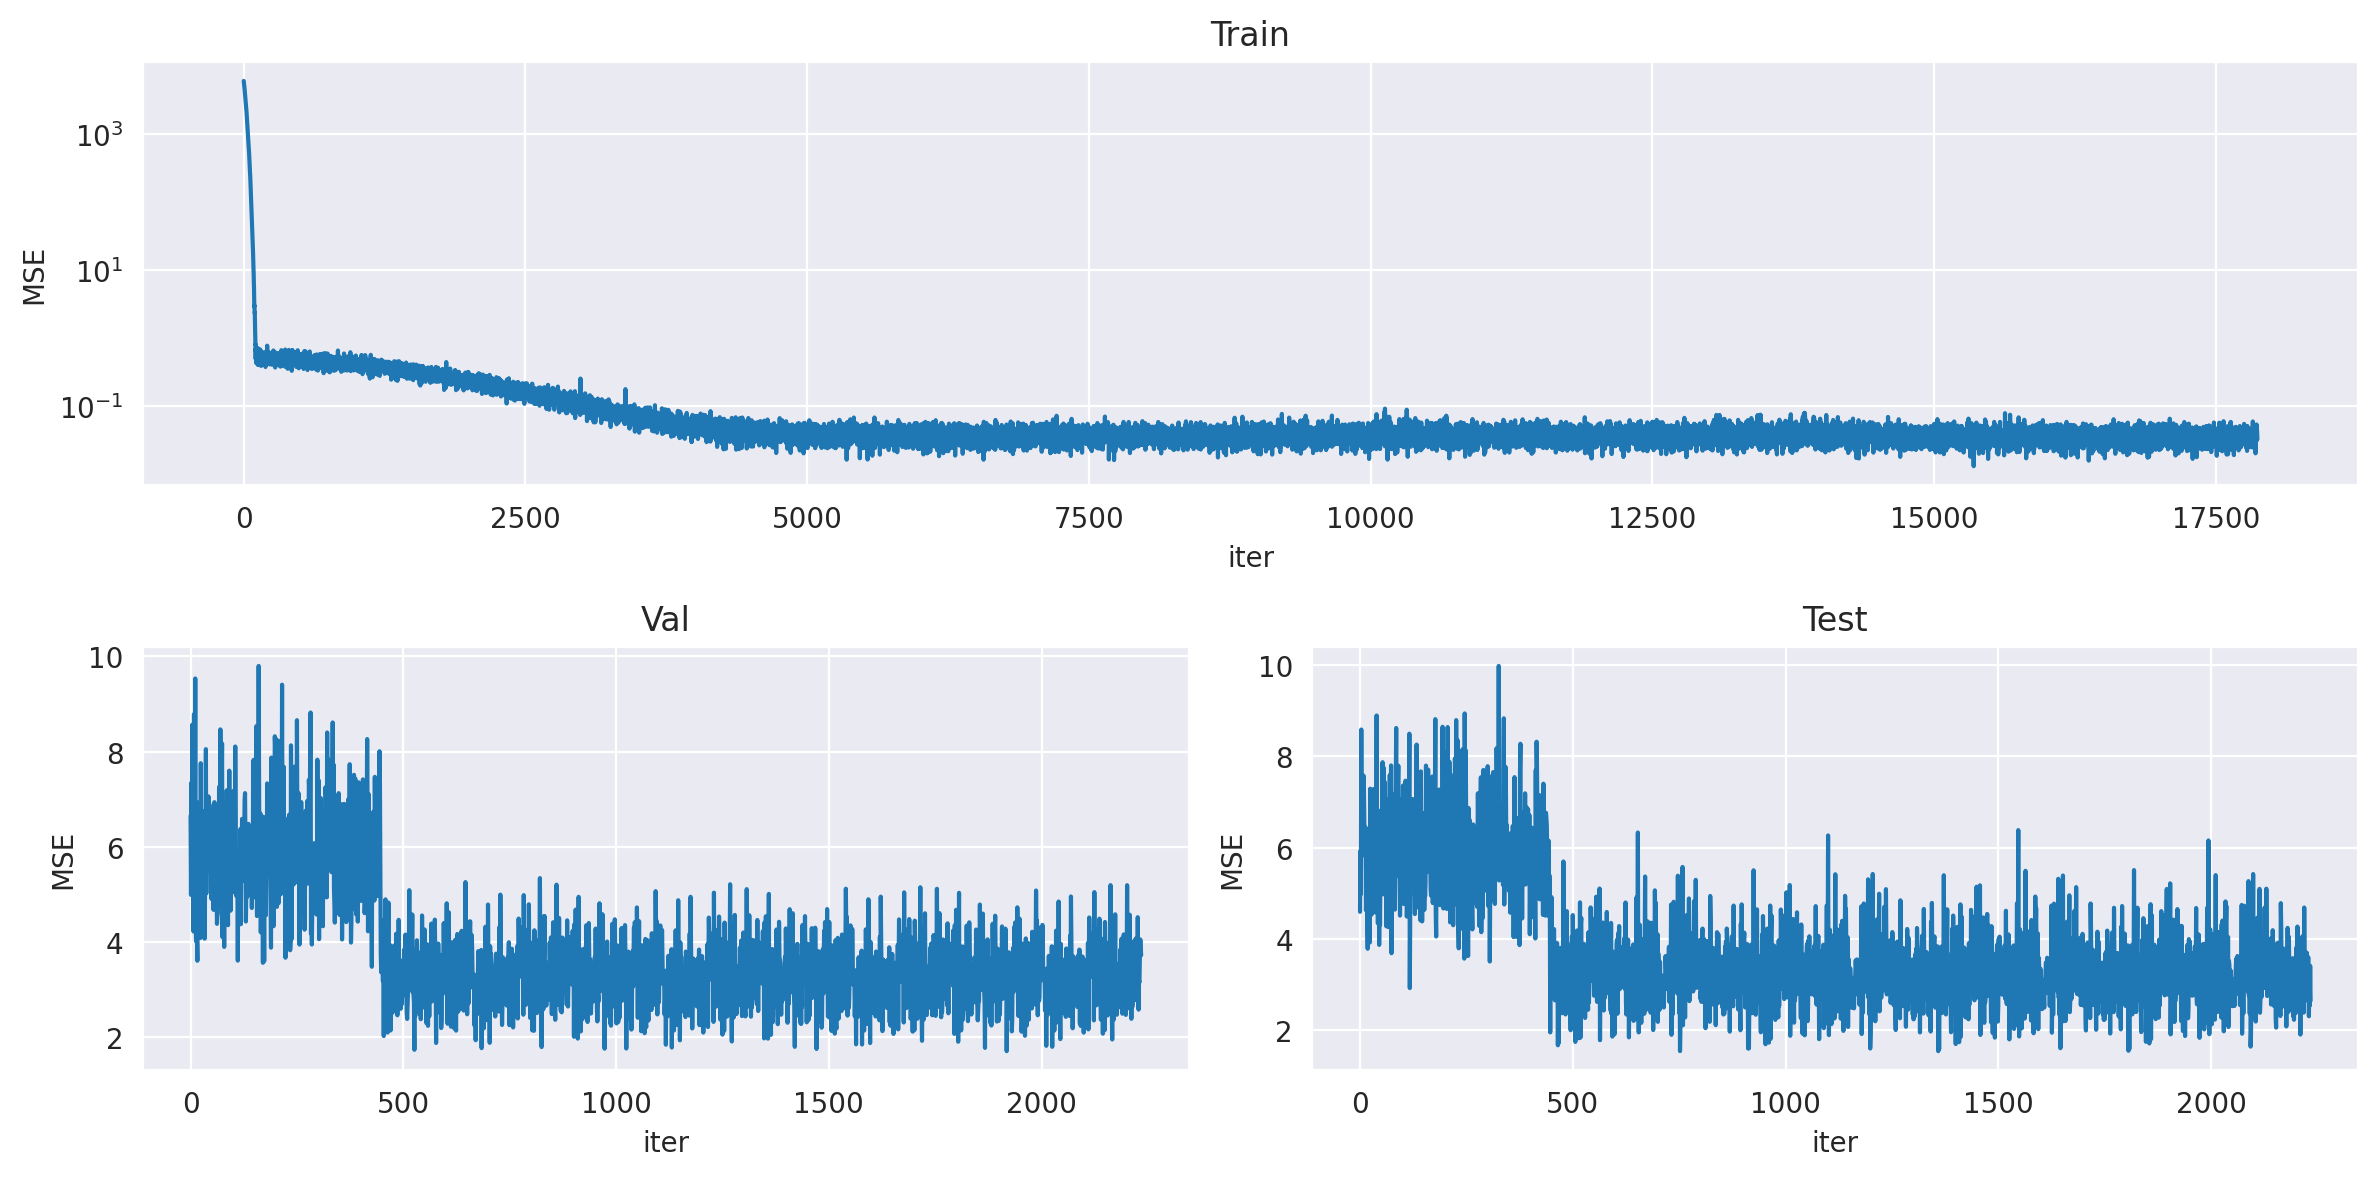

1.8109167

In [125]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

### Усложним архитектуру добаим третий слой:
1. 2 слоя (128 нейронов) + (64 нейрона)
2. AdamW
3. lr = 1e-4
4. CosineAnnealingLR

Epoch: 5
Test RMSE: 1.8374875783920288


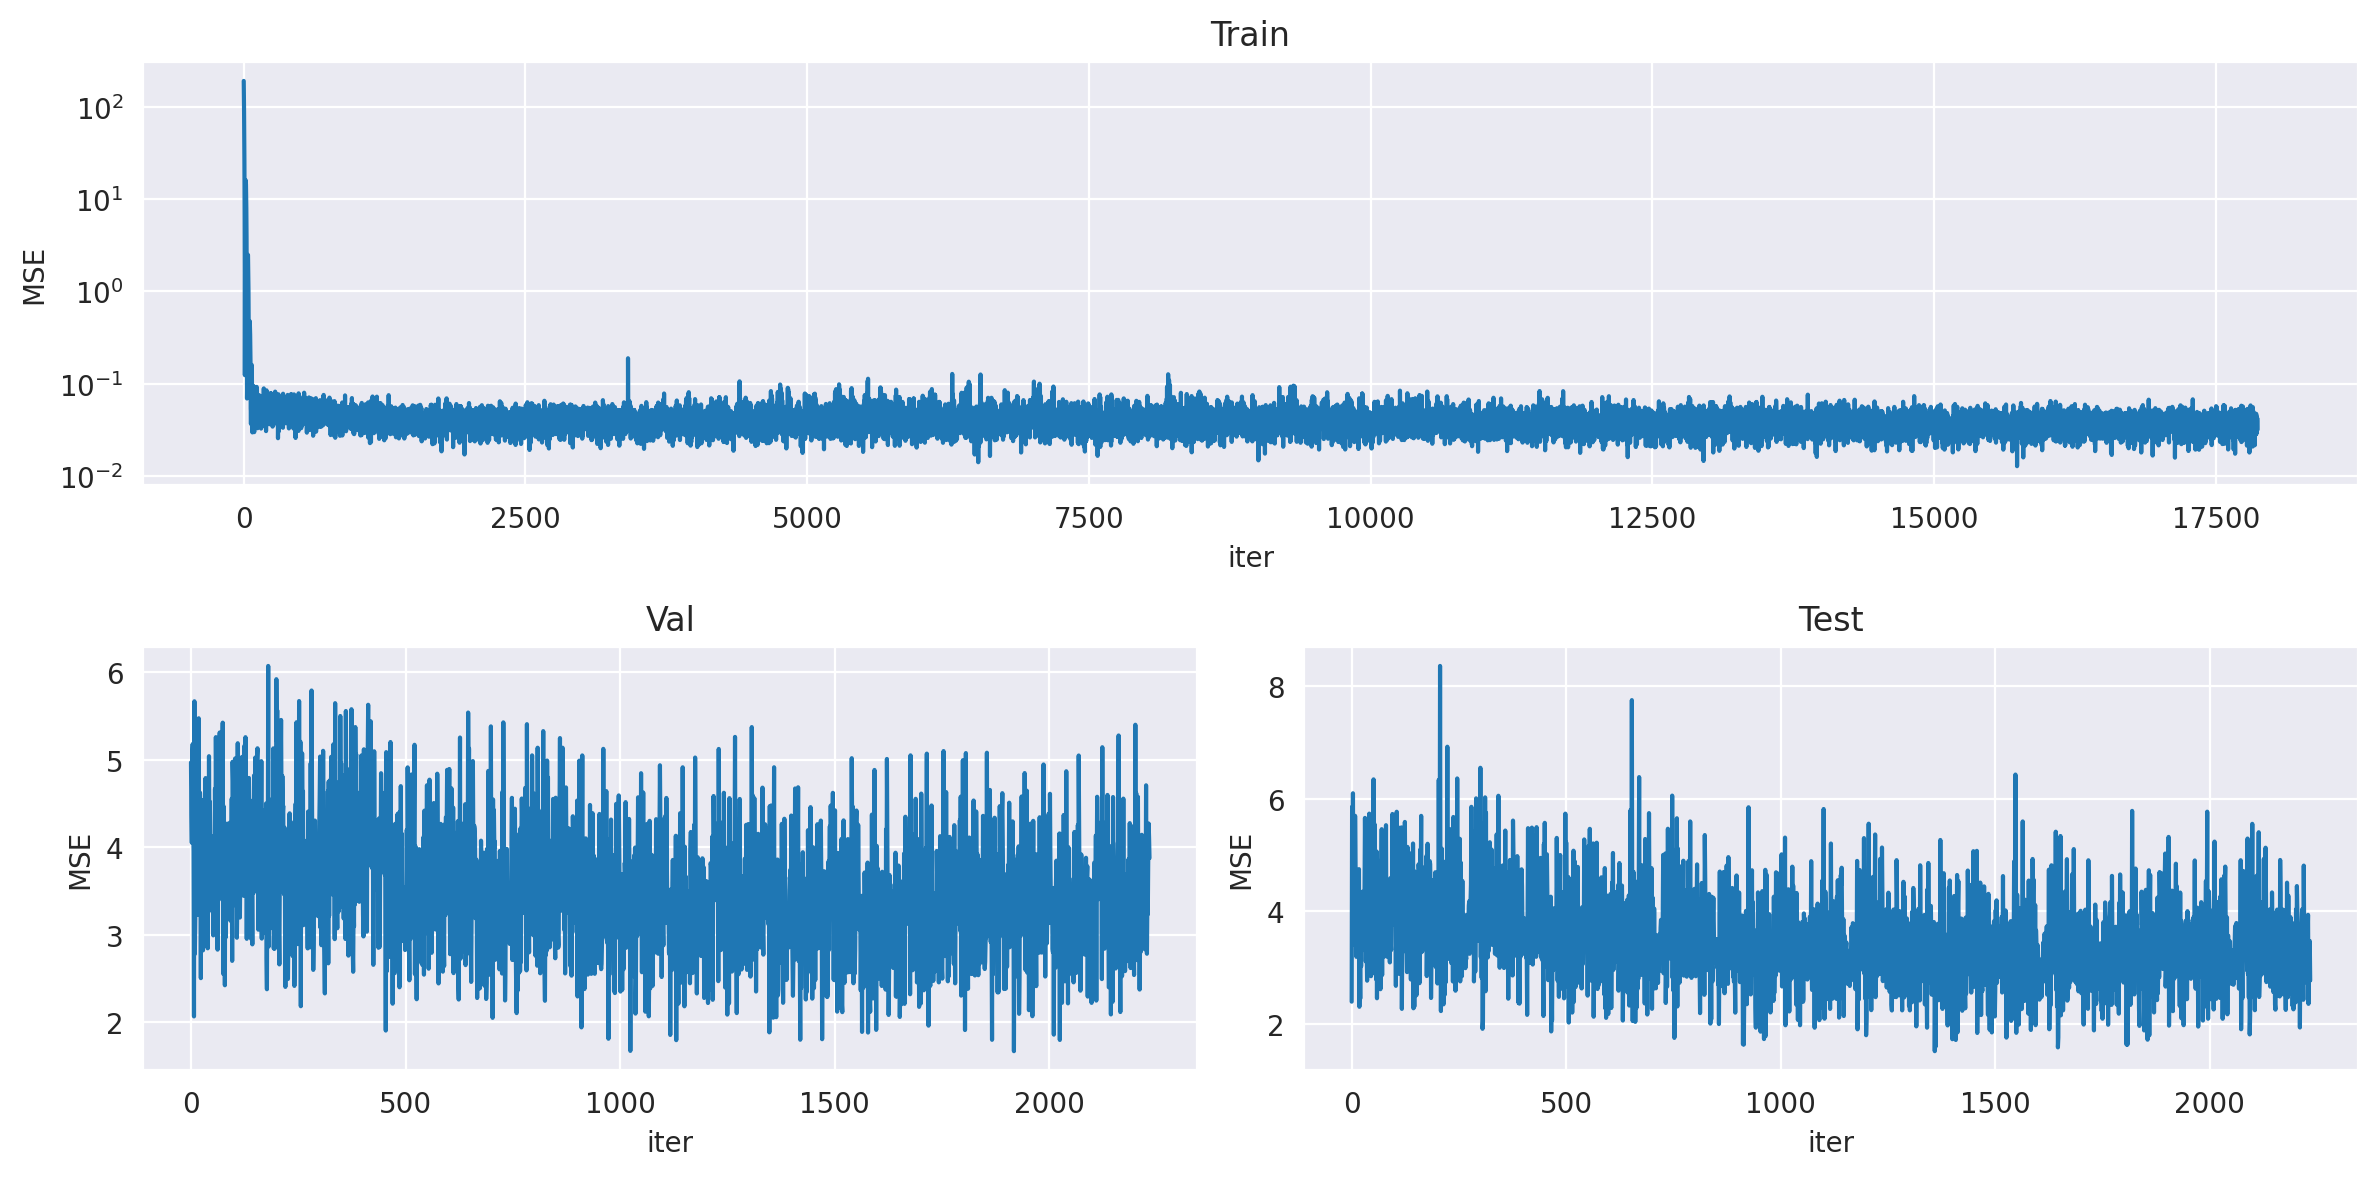

1.8374876

In [128]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

### Усложним архитектуру добаим BatchNorm:
1. 2 слоя (128 нейронов) + batchnorm + (64 нейрона) + batchnorm
2. AdamW
3. lr = 1e-4
4. CosineAnnealingLR


Epoch: 5
Test RMSE: 1.7784717082977295


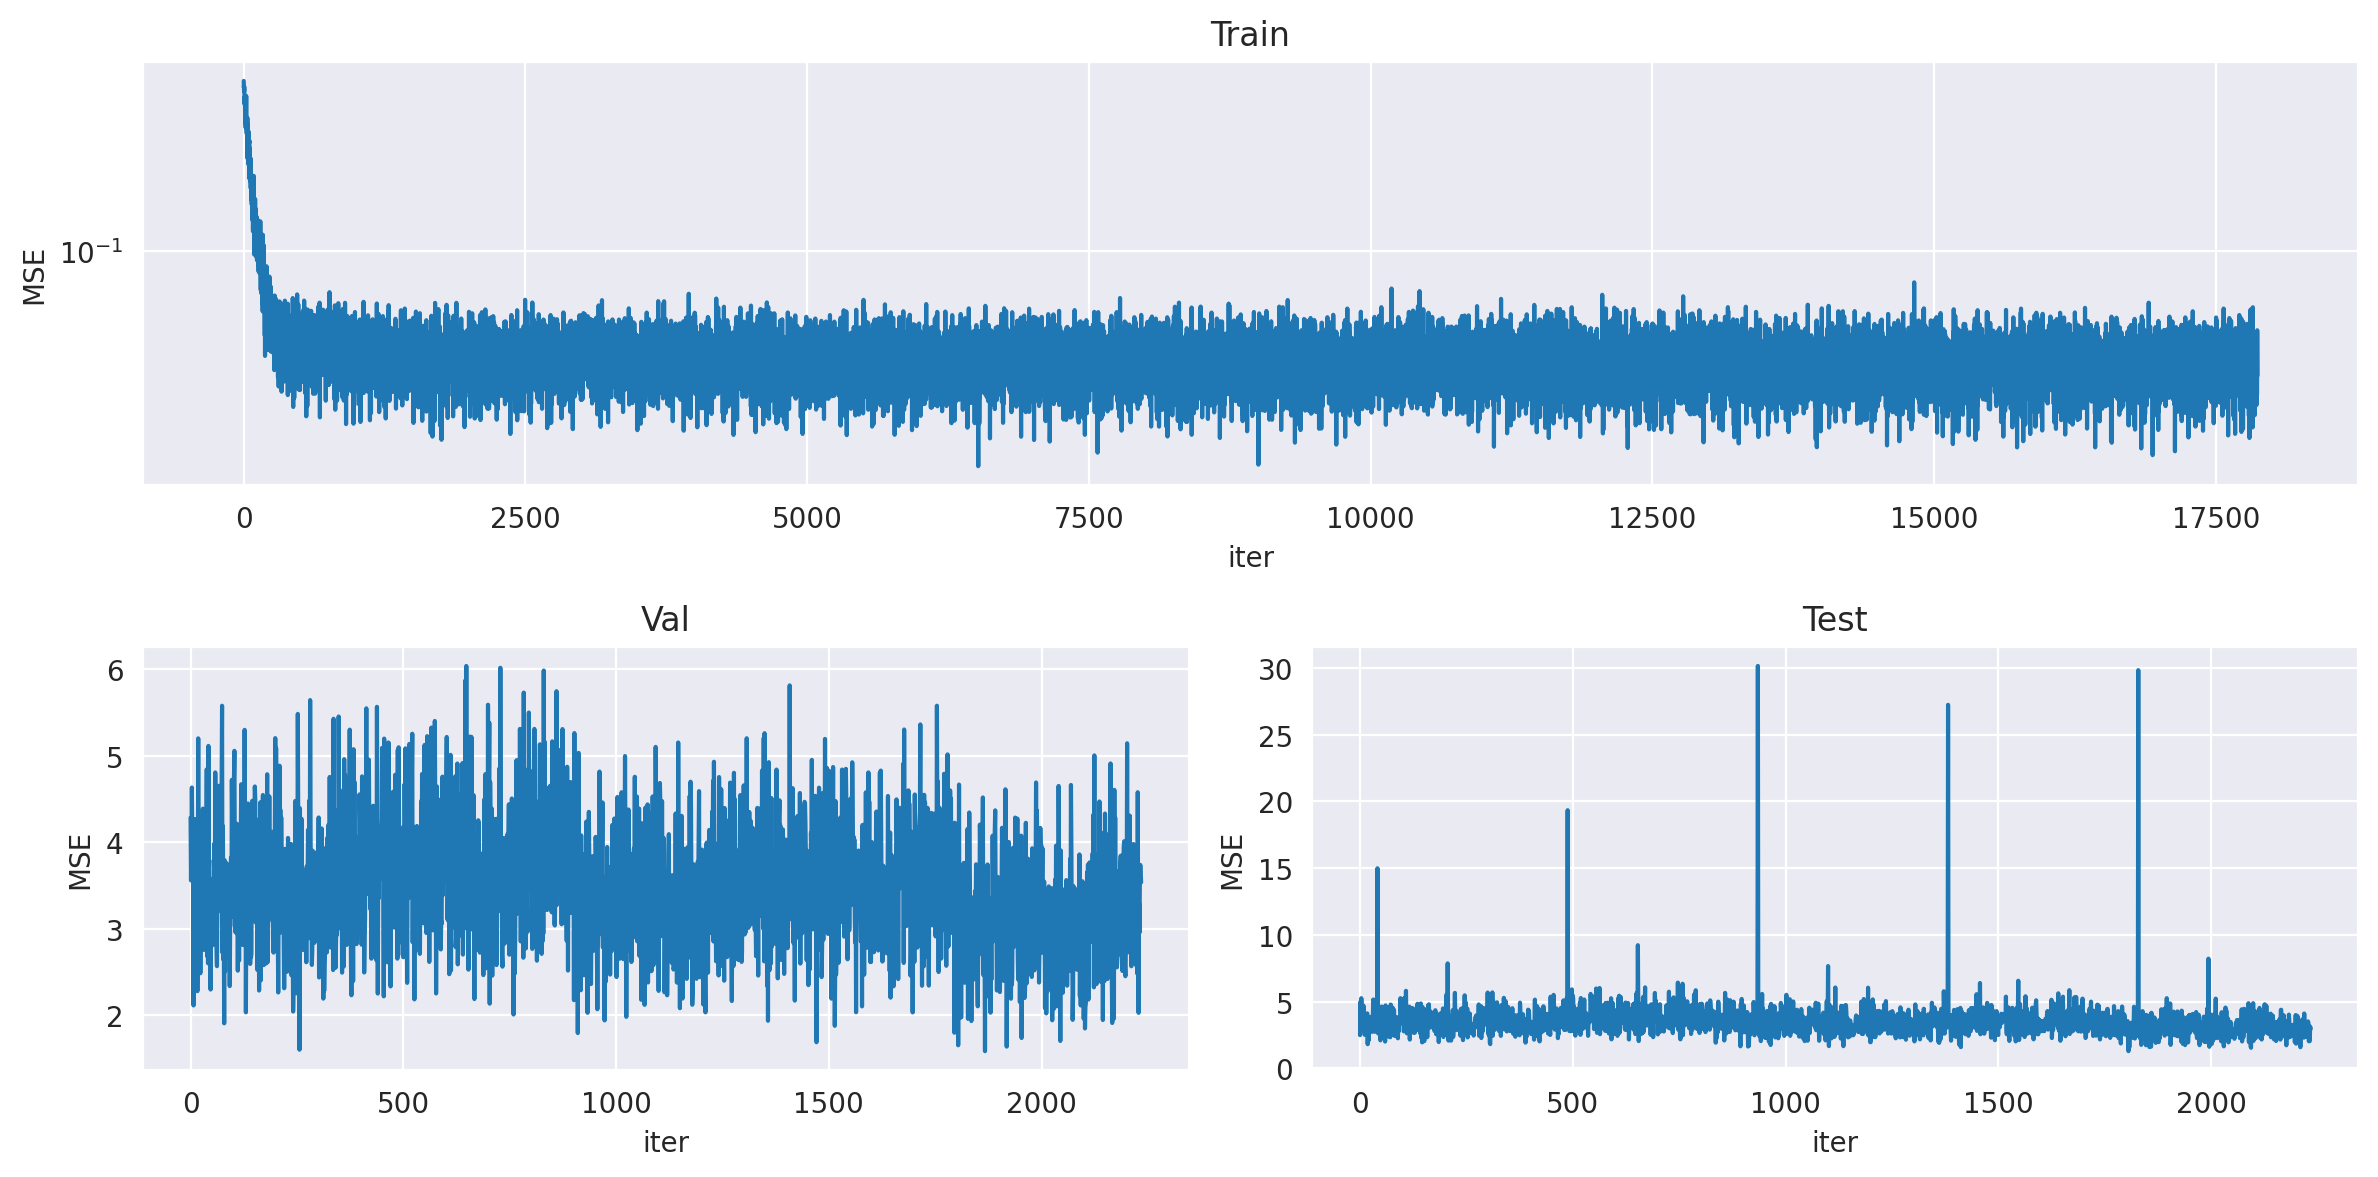

1.7784717

In [129]:
seed_everything(42)

class TMDB(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.batchn1 = nn.BatchNorm1d(128)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.batchn2 = nn.BatchNorm1d(64)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batchn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.batchn2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

model = TMDB(X_train.shape[1]).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5)
criterion = F.mse_loss

fit(model, train_loader, val_loader, test_loader, optimizer, criterion, 5, device, target_scaler)

___